In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from tqdm import tqdm
import features_extraction_modul as fem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

plt.rcParams["figure.figsize"] = (30,20)
pd.options.display.precision = 12

In [2]:
ef_path = "extracted_features_large/"
files = os.listdir(ef_path)

In [3]:
x_pd_array = []
y_pd_array = []
for f in files:
    print(f)
    i_ef =  pd.read_csv(ef_path+f)
    if f[0] == "x":
        x_pd_array.append(i_ef)
    else:
        y_pd_array.append(i_ef)

x_train00.csv
x_train01.csv
x_train02.csv
x_train03.csv
x_train04.csv
x_train05.csv
x_train06.csv
x_train07.csv
x_train08.csv
x_train09.csv
x_train10.csv
x_train11.csv
x_train12.csv
x_train13.csv
x_train14.csv
x_train_t9_02.csv
x_train_t9_07.csv
x_train_t9_14.csv
y_train00.csv
y_train01.csv
y_train02.csv
y_train03.csv
y_train04.csv
y_train05.csv
y_train06.csv
y_train07.csv
y_train08.csv
y_train09.csv
y_train10.csv
y_train11.csv
y_train12.csv
y_train13.csv
y_train14.csv
y_train_t9_02.csv
y_train_t9_07.csv
y_train_t9_14.csv


In [4]:
x_train = pd.concat(x_pd_array, ignore_index = True).iloc[:, 1:]
y_train = pd.concat(y_pd_array, ignore_index = True).iloc[:, 1:]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 101)

In [6]:
#normalizing the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_train_flatten = y_train.values.ravel() #flattening the y_train
y_test_flatten = y_test.values.ravel() #flattening the y_test

In [7]:
print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train_flatten.shape)
print(y_test_flatten.shape)

(4220, 98)
(1056, 98)
(4220,)
(1056,)


In [9]:
def GetModel():
    nInputs = x_train_scaled.shape[1]
    inputs = tf.keras.Input(shape=(nInputs, ), name = "features")
    activation = tf.keras.layers.Activation(tf.nn.leaky_relu)
    x = inputs
    for iLayer in range(0,5):
        dense = 1024/2**(iLayer)
        x = tf.keras.layers.Dense(dense, activation=activation, name="layer_{}".format(iLayer))(x)
        x = tf.keras.layers.Dropout(0.35)(x)
    
    outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.relu,
                               bias_initializer='zeros',
                               name = "time")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name = "NN1")
    initial_learning_rate = 0.00005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)
  
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=['mean_absolute_error'])
    tf.keras.utils.plot_model(model, 'ML_model.png', show_shapes=True)
    return model
    
    

In [10]:
model = GetModel()
model.summary()
nEpochs = 30

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(x_train_scaled, y_train_flatten , epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=2,
                    shuffle=True,
                    validation_data= (x_test_scaled, y_test_flatten),
                    #callbacks=[callback]
                   )


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "NN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 98)]              0         
_________________________________________________________________
layer_0 (Dense)              (None, 1024)              101376    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
layer_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer_2 (Dense)          

In [11]:
prediction_score = []
mae_scores = []
predictions = model.predict(x_test_scaled, verbose = 1) #make predictons on the test data 
prediction_score.append(predictions)

mae = mean_absolute_error(predictions, y_test_flatten) #calculating MAE between our actual output labels and the predicted otuput labels
mae_scores.append(mae)

33/33 [==============================] - 0s 2ms/step


In [72]:
y_test_array = np.atleast_2d(y_test_flatten).T

pred_test = pd.DataFrame(data = np.column_stack((predictions, y_test_array)), columns = ["predictions", "test"])

In [69]:
pred_test = pred_test.set_index('test', append=True).sort_index(level=1).reset_index(level=1)


In [77]:
 pred_test.set_index('test', append=True).sort_index(level=1).reset_index(level=1)

,test,predictions
979,0.022398350760,8.807090759277
10,0.023996518925,13.707501411438
463,0.031396131963,9.611731529236
154,0.036997921765,9.316563606262
351,0.046296402812,13.677889823914
...,...,...
95,15.600999832153,15.379594802856
90,15.692497253418,11.979205131531
748,15.847799301147,13.282786369324
184,15.952097892761,12.910617828369


In [12]:
print(np.mean(mae_scores)) #average of mean absolute errors


2.5080805721967905


In [83]:
x_train_unsplited = pd.concat(x_pd_array, ignore_index = True).iloc[:, 1:]
y_train_unsplited = pd.concat(y_pd_array, ignore_index = True).iloc[:, 1:]

#normalizing the data
scaler = StandardScaler()
scaler.fit(x_train_unsplited )
x_train_unsplited_scaled = scaler.transform(x_train_unsplited )

y_train_flatten_unsplited = y_train_unsplited.values.ravel() #flattening the y_train

predictions = model.predict(x_train_unsplited_scaled, verbose = 1) #make predictons on the test data 

y_train_array = np.atleast_2d(y_train_flatten_unsplited).T

pred_test = pd.DataFrame(data = np.column_stack((predictions, y_train_array)), columns = ["predictions", "test"])

165/165 [==============================] - 0s 3ms/step


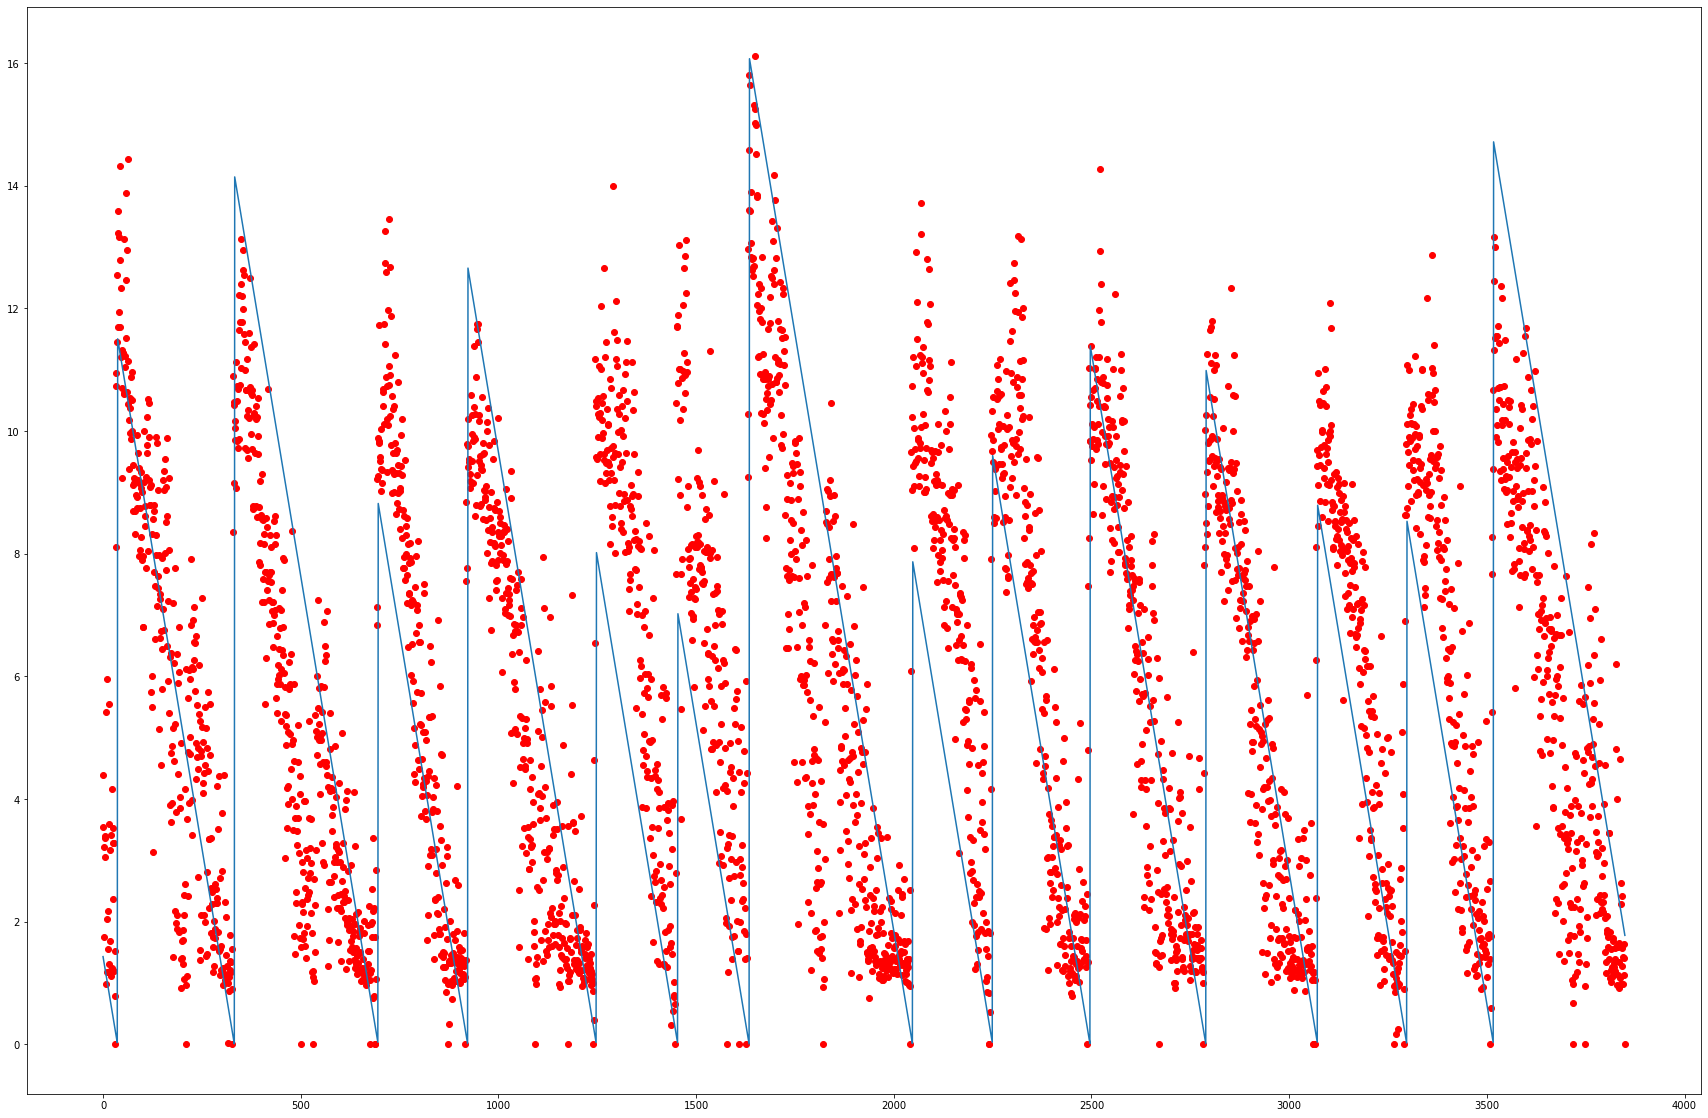

In [94]:
plt.plot(pred_test["test"][:3850])
plt.scatter(pred_test.index[:3850] ,pred_test["predictions"][:3850], color='red')

In [133]:
ef_sample_submission = pd.read_csv("ef_sample_submission.csv")

In [134]:
ef_sample_submission = ef_sample_submission.iloc[:, 1:]
seg =  ef_sample_submission.iloc[:, 0:1]
ef_sample_submission = ef_sample_submission.iloc[:, 1:]

In [135]:
X_test_scaled = scaler.transform(ef_sample_submission)


In [136]:
predictions = model.predict(X_test_scaled, verbose = 1)


82/82 [==============================] - 0s 4ms/step


In [137]:
predictions

array([[ 3.550687 ],
       [ 7.5158644],
       [ 5.4722347],
       ...,
       [ 3.8041677],
       [ 1.8148482],
       [12.161914 ]], dtype=float32)

In [138]:
np.column_stack([seg, predictions])

array([['seg_00030f', 3.550687074661255],
       ['seg_0012b5', 7.515864372253418],
       ['seg_00184e', 5.472234725952148],
       ...,
       ['seg_ff79d9', 3.8041677474975586],
       ['seg_ffbd6a', 1.8148481845855713],
       ['seg_ffe7cc', 12.161913871765137]], dtype=object)

In [139]:
final = pd.DataFrame(np.column_stack([seg, predictions]))
final["seg_id"] =  final.iloc[:, 0:1]
final["time_to_failure"] = final.iloc[:, 1:2]
final = final.iloc[:, 2:]
final["time_to_failure"] = final["time_to_failure"].astype("float64")
final.to_csv("sample_submission.csv", index = False )